In [134]:
import copy
import enum
import numpy as np
import random
from typing import Callable
from typing import Mapping
from typing import Optional
from typing import Sequence
from typing import Tuple
from typing import TypeVar

import graphviz
import matplotlib.pyplot as plt
import torch
import tqdm

# Temporal-Difference Learning

## <p style="color:red">Text content copied near verbatim from: <a href="http://incompleteideas.net/book/the-book-2nd.html">Sutton and Barto</a>. Code is my own unless otherwise stated.</p>

## Key Concepts

- TD relation to Monte Carlo and DP methods.

- Batch MC vs Batch TD:

## Definitions

**TD(0) / _n-step_ TD**: 

**TD error**:

**Markov Reward Process**:

**Batch Updating**:

**Certainty-equivalence estimate**:

## Notation

TODO

## Introduction

Temporal-difference (TD) learning is a combination of Monte Carlo ideas and dynamic programming (DP) ideas.

Like Monte Carlo methods, TD methods can directly learn from raw experience without a model of the environment's dynamics.

Like DP, TD methods update estimates based in part on other learned estimates, without waiting for a final outcome (they _bootstrap_).

DP, TD, and Monte Carlo methods all use some form of generalized policy iteration (GPI) to solve the control problem. The differences in the methods are primarily due to differences in their approaches to the prediction problem.

## TD Prediction

Both TD and Monte Carlo methods use experience to solve the prediction problem. Given some experience following a policy $\pi$, both methods update their estimate $V$ of $v_\pi$ for the nonterminal states $S_t$ occurring in that experience. 

---

Monte Carlo methods wait until the return following the visit is known, then use that return as a target for $V(S_t)$. A simple every-visit Monte Carlo method suitable for nonstationary environments is the _constant-$\alpha$ MC_:

\begin{equation}
    V(S_t) \leftarrow V(S_t) + \alpha \left[ G_t - V(S_t) \right]
\end{equation}

where $G_t$ is the actual return following time $t$ and $\alpha$ is a constant step-size parameter.

Monte Carlo methods must wait until the end of the episode to determine the increment to $V(S_t)$ (only then is $G_t$ known).

---

TD methods only need to wait until the next time step to determine the increment. At time $t + 1$ they immediately form a target and make a useful update using the observed reward $R_{t + 1}$ and the estimate $V(S_{t + 1})$. The simplest TD method makes the update

\begin{equation}
    V(S_t) \leftarrow V(S_t) + \alpha \left[ R_{t + 1} + \gamma V(S_{t + 1}) - V(S_t) \right]
\end{equation}

immediately on transition to $S_{t + 1}$ and receiving $R_{t + 1}$. 

---

In effect, the target for the Monte Carlo update is $G_t$ whereas the target for the TD update is $R_{t + 1} + \gamma V(S_{t + 1})$. 

This TD method is called $TD(0)$ or _one-step_ TD because it is a special case of the TD($\lambda$) and _n-step_ TD methods developed in Chapters 12 and 7. 

In [2]:
StateT = TypeVar("StateT")
ActionT = TypeVar("ActionT")
RewardT = TypeVar("RewardT", int, float)

TraceT = Sequence[Tuple[StateT, ActionT, RewardT]]

In [3]:
def tabular_td0(
    policy: Mapping[StateT, Mapping[ActionT, float]],
    init_state: Callable[[], StateT],
    is_terminal: Mapping[StateT, bool],
    simulate: Callable[[StateT, ActionT], Tuple[StateT, RewardT]],
    n_episode: int,
    alpha: float = 0.1,
    gamma: float = 1.0,
    init_fn: Optional[Callable[[StateT], float]] = None
) -> Mapping[StateT, float]:
    state_values = {}
    
    for state in policy.keys():
        state_values[state] = 0 if init_fn is None else init_fn(state) 
        
    for _ in tqdm.trange(n_episode):
        state = init_state()
        
        while not is_terminal[state]:
            action = random.choices(
                population=list(policy[state].keys()), 
                weights=policy[state].values()
            )[0]   # random.choices returns a 1-element list
            next_state, reward = simulate(state, action)

            state_values[state] += alpha*(reward + gamma*state_values[next_state] - state_values[state])
            
            state = next_state
            
    return state_values

---

Confirming this works on the simple grid-world environment from Example 4.1 in Chapter 4:

In [4]:
gw_states: Sequence[int] = list(range(4*4))   # 4x4 grid, states numbered left to right top to bottom 

    
class GWAction(enum.Enum):
    UP    = enum.auto()
    DOWN  = enum.auto()
    RIGHT = enum.auto()
    LEFT  = enum.auto()

    
def gw_init_state() -> int:
    return random.choice(gw_states)


gw_is_terminal: Mapping[int, bool] = {
    state: state == 0 or state == 15
    for state in gw_states
}


def gw_simulate(state: int, action: GWAction) -> Tuple[int, float]:
    """
        
    """
    if action == GWAction.LEFT:
        if state % 4 == 0:
            #  unable to move further left
            return state, -1
        return state - 1, -1
    
    if action == GWAction.RIGHT:
        if (state + 1) % 4 == 0:
            # unable to move further right
            return state, -1
        return state + 1, -1
    
    if action == GWAction.UP:
        if state < 4:
            return state, -1
        return state - 4, -1
    
    if action == GWAction.DOWN:
        if state > 11:
            return state, -1
        return (state + 4) % 15, -1 

    raise ValueError(state, action)

In [5]:
gw_equiprob_policy = {}
for state in gw_states:
    gw_equiprob_policy[state] = {}
    for action in GWAction:
        gw_equiprob_policy[state][action] = 1.0 / len(GWAction)

In [8]:
state_values = tabular_td0(
    policy=gw_equiprob_policy,
    init_state=gw_init_state,
    is_terminal=gw_is_terminal,
    simulate=gw_simulate,
    n_episode=int(1e6),
    alpha=0.0001,
    gamma=1.0
)

100%|██████████| 1000000/1000000 [00:41<00:00, 24020.41it/s]


In [9]:
for i in range(4):
    for j in range(4):
        print(f"{state_values[i*4 + j]: 7.3f}", end=' ')
    print()

  0.000 -13.902 -19.942 -21.965 
-14.028 -17.943 -19.976 -20.052 
-20.013 -19.993 -18.052 -14.233 
-22.011 -19.972 -13.981   0.000 


Recall that the actual state-value function for this problem is:

```
| 0.0 | -14 | -20 | -22 |
| -14 | -18 | -20 | -20 |
| -20 | -20 | -18 | -14 |
| -22 | -20 | -14 | 0.0 |
```

so we see that the method works!

Notice that $\alpha$ must be small for the computed values to get close to their true value.

---

TD(0) bases its update in part on an existing estimate so it is a _bootstrapping_ method like DP. We know from Chapter 3 that:

\begin{align}
    v_\pi(s) &\doteq \mathbb{E}_\pi \left[ G_t | S_t = s \right] \\
             &= \mathbb{E}_\pi \left[ R_{t + 1} + \gamma G_{t + 1} | S_t = s \right] \\
             &= \mathbb{E}_\pi \left[ R_{t + 1} + \gamma v_\pi(S_{t + 1}) | S_t = s \right]
\end{align}

Monte Carlo methods use an estimate of $\mathbb{E}_\pi[G_t | S_t = s]$ as the target. It is an estimate as the expected value is not known; a sample return is used in place of the real expected return.

DP methods use an estimate of $\mathbb{E}_\pi[R_{t + 1} + \gamma v_\pi(S_{t + 1}) | S_t = s]$ as the target. It is an estimate not because of the expected values, which are assumed to be completely provided by a model of the environment, but because $v_\pi(S_{t + 1})$ is not known and the current estimate $V(S_{t + 1})$ is used instead.

The TD target is an estimate for both reasons:

1. It samples the expected values.
2. It uses the current estimate $V$ instead of the true $v_\pi$.

**TD methods combine the sampling of Monte Carlo with the bootstrapping of DP.**

---

Note that in the update rule for TD the quantity in brackets, $\left[ R_{t + 1} + \gamma V(S_{t + 1}) - V(S_t) \right]$, is a sort of error measuring the difference between the estimated value of $S_t$ and the better estimate $R_{t + 1} + \gamma V(S_{t + 1})$. This is called the **TD error** and arises in various forms throughout reinforcement learning:

\begin{equation}
    \delta_t \doteq R_{t + 1} + \gamma V(S_{t + 1}) - V(S_t)
\end{equation}

This quantity depends on the next state and reward so is not available until one time step later. If the array V does not change during the episode (e.g. Monte Carlo methods) then the Monte Carlo error can be written as a sum of TD errors:

\begin{align}
    G_t - V(S_t) &= R_{t + 1} + \gamma G_{t + 1} - V(S_t) \\
                 &= R_{t + 1} + \gamma G_{t + 1} - V(S_t) + \gamma V(S_{t + 1}) - \gamma V(S_{t + 1}) \\
                 &= \delta_t + \gamma \delta_{t + 1} + \gamma^2(G_{t + 2} - V(S_{t + 2})) \\
                 &= \delta_t + \gamma \delta_{t + 1} + \gamma^2\delta_{t + 2} + \dots + \gamma^{T - t - 1} \delta_{T - 1} + \gamma^{T - t}(0 - 0) \\
                 &= \sum_{k = t}^{T - 1} \gamma^{k - t} \delta_k
\end{align}

---

Exercise 6.1: If V changes during the episode then the above only holds approximately; what would the difference be between the two sides? Let $V_t$ denote the array of state values used at time $t$ in the TD error and in the TD update. Redo the derivation above to determine the additional amount that must be added to the sum of TD errors in order to equal the Monte Carlo error.

\begin{align}
    V_{t + 1}(S_t) &= V_t(S_t) + \alpha [R_{t + 1} + \gamma V_t(S_{t + 1}) - V_t(S_t)] \\
                   &= V_t(S_t) + \alpha [R_{t + 1} + \gamma V_t(S_{t + 1}) - V_t(S_t)] \\
                   &= V_t(S_t) + \alpha \delta_t \\
\end{align}

Rearranging for $V_t(S_t)$

\begin{align}
    V_t(S_t) &= V_{t + 1}(S_t) - \alpha \delta_t
\end{align}

Following through with the proof similar to the steps in (6.6):

\begin{align}
    G_t - V_t(S_t) &\doteq R_{t + 1} + \gamma G_{t + 1} - V_t(S_t) \\
                   &=      R_{t + 1} + \gamma V_t(S_{t + 1}) - V_t(S_t) + \gamma G_{t + 1} - \gamma V_t(S_{t + 1}) \\
                   &= \delta_t + \gamma(G_{t + 1} - V_t(S_{t + 1})) \\
                   &= \delta_t + \gamma(G_{t + 1} - V_{t + 1}(S_{t + 1}) + \alpha \delta_t) \\
                   &= \delta_t + \gamma \alpha \delta_t + \gamma(G_{t + 1} - V_{t + 1}(S_{t + 1})) \\
                   &= \delta_t(1 + \gamma \alpha) + \gamma(G_{t + 1} - V_{t + 1}(S_{t + 1})) \\
                   &= \delta_t(1 + \gamma \alpha) + \gamma(\delta_{t + 1}(1 + \gamma \alpha) + \gamma(G_{t + 2} - V_{t + 2}(S_{t + 2}))) \\
                   &= \delta_t(1 + \gamma \alpha) + \gamma(\delta_{t + 1}(1 + \gamma \alpha)) + \gamma(G_{t + 2} - V_{t + 2}(S_{t + 2})) \\
                   &= (1 + \gamma \alpha)(\delta_t + \gamma\delta_{t + 1}) + \gamma^2(\delta_{t + 2}(1 + \gamma \alpha) + \gamma(G_{t + 3} - V_{t + 3}(S_{t + 3}))) \\
                   &= (1 + \gamma \alpha)(\delta_t + \gamma\delta_{t + 1}) + \gamma^2\delta_{t + 2}(1 + \gamma \alpha) + \gamma^3(G_{t + 3} - V_{t + 3}(S_{t + 3})) \\
                   &= (1 + \gamma \alpha)(\delta_t + \gamma\delta_{t + 1} + \gamma^2\delta_{t + 2}) + \gamma^3(G_{t + 3} - V_{t + 3}(S_{t + 3})) \\
                   &= (1 + \gamma \alpha)\sum_{k=t}^{T - 1}\gamma^{k - t} \delta_t 
\end{align}

Intuitively this makes sense.

To see why, first note that the original equation _without_ the time subscript telescopes to produce the sum of discounted rewards equation. This is a convoluted way of getting from the RHS back to the LHS :-)

\begin{equation}
    \delta_t \doteq R_{t + 1} + \gamma V(S_{t + 1}) - V(S_t)
\end{equation}


\begin{align}
    G_t - V(S_t) &= \sum_{k = t}^{T - 1} \gamma^{k - t} \delta_k \\
                 &= R_{t + 1} + \gamma V(S_{t + 1}) - V(S_t) + \gamma ( R_{t + 2} + \gamma V(S_{t + 2}) - V(S_{t + 1})) + \sum_{k = t + 2}^{T - 1} \gamma^{k - t} \delta_k \\
                 &= R_{t + 1} + \gamma V(S_{t + 1}) - V(S_t) + \gamma R_{t + 2} + \gamma^2 V(S_{t + 2}) - \gamma  V(S_{t + 1}) + \sum_{k = t + 2}^{T - 1} \gamma^{k - t} \delta_k \\
                 &= R_{t + 1} + \gamma R_{t + 2} - V(S_t) + \gamma^2 V(S_{t + 2})+ \sum_{k = t + 2}^{T - 1} \gamma^{k - t} \delta_k \\
                 &= \left[\sum_{k = t + 1}^{T} \gamma^{k - t - 1}R_{k}\right] - V(S_t)
\end{align}

Now, from the above we also know:

\begin{equation}
    V_{t + 1}(S_t) - V_t(S_t) = \alpha \delta_t
\end{equation}

Distributing the summation gives:

\begin{align}
    G_t - V_t(S_t) &= (1 + \gamma \alpha) \sum_{k = t}^{T - 1} \gamma^{k - t}\delta_t \\
                   &= \sum_{k = t}^{T - 1} \gamma^{k - t}\delta_t + \gamma \alpha \sum_{k = t}^{T - 1} \gamma^{k - t}\delta_t \\
                   &= \sum_{k = t}^{T - 1} \gamma^{k - t}\delta_t + \sum_{k = t}^{T - 1} \gamma^{k - t + 1} \alpha \delta_t \\
                   &= \sum_{k = t}^{T - 1} \gamma^{k - t} \delta_t + \gamma^{k - t + 1} \alpha \delta_t
\end{align}

It is the original sum of discounted TD errors plus another term. This other term accounts for the sum of discounted differences/deltas between the state-value estimate at step $t + 1$ and at step $t$. i.e. it is the difference, $\alpha \delta_k$, weighted by the discounting factor.

---

Example 6.1: Driving Home (/Exercise 6.2)

Consider driving home and at various points estimating the time remaining. This can be considered an RL problem where the state is the weather, your location, current time etc. The rewards are the negated time taken to get to the point on your journey home. The value function is the negated estimate of how long you think it should take to get home from the current state.

Let $\gamma = 1$ and $\alpha = 1$. 

For Monte Carlo methods the error, $G_t - V(S_t)$ is the difference between the actual time taken and the estimated time remaining. This requires knowing how long the journey took in total so updates can only be done offline. It also means that changes that occur in just one state can have big impacts as to the predicted times of all other states, even if in practice they are unchanged. 

For methods that use temporal difference learning the error is $R_t + \gamma V(S_{t + 1}) - V(S_t)$. The estimated return, in this case time remaining, can be updated as soon as the next state and reward are known. In the case of driving home, if you predict it will take 30 minutes to get home and it takes 5 minutes to reach the next state where you now think it will take 20 minutes, the prior estimate can be updated by $5 + 20 - 30 = -5$ minutes _without_ needing to actually reach your house.

Note that this means if your next state has an accurate estimate of the time taken to reach home then you are able to quickly converge the current state's estimate to the true expected value. Consider changing jobs to one that is in a different location but after a slightly different, longer start uses the same route home. For MC Methods the error for all states will initially be increased despite it only being the few starting states that have changed and they will need to be decreased again as the starting states converge.For TD methods only these initial states will be updated. 

--- 

### Advantages of TD Prediction Methods

**Bootstrap**: Learning to guess from a guess. TD methods update their estimates based in part on other estimates.

TD Method Advantages:

1. Compared to DP methods, they do not require a model of the environment (DP methods use to compute expectation over all possible next states and rewards). 
2. Compared to Monte Carlo methods, they can be implemented in an online, fully incremental fashion (Monte Carlo methods must wait until the end of the episode to get the final reward). Some applications have very long episodes where delaying all learning until the end of the episode is too slow. Other applications have no episodes at all! 
3. Compared to Monte Carlo methods, TD methods can learn from each transition regardless of what subsequent actions are taken. Some Monte Carlo methods must ignore or discount episodes on which experimental actions are taken, which can greatly slow learning (if action is non-greedy towards end of episode, importance sampling ratio is zero and therefore all updates at time before the step become zero).


Convergence can be guaranteed for TD methods: for any fixed policy $\pi$, $TD(0)$ has been proved to converged to $v_\pi$. In the mean for a constant step size parameter if it is sufficiently small or with probability 1 if it decreases. 


It is an open question as to which of Monte Carlo or TD methods are more data efficient/learns faster. In practice TD methods have usually been found to converge faster than constant-$\alpha$ MC methods on stochastic tasks.

---

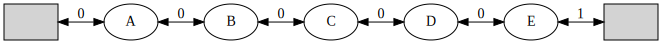

In [10]:
# Example 6.2: Random Walk

# A Markov reward process (MRP) is a MDP without actions.
#
# MRPs are often useful when focusing on the prediction problem is which there is no need
# to distinguish between the dynamics due to the environment and those due to the agent.
# (i.e. the state->action, action->next state probabilities collapse to state->next state)
#
# Consider the MRP:

g = graphviz.Digraph(graph_attr={"rankdir": "LR"})

nodes = [
    "endL", "A", "B", "C", "D", "E", "endR"
]
for n in nodes:
    end = "end" in n
    g.node(
        n,
        label=None if not end else "",
        shape="box" if end else None,
        style="filled" if end else None,
    )
    
for l, r in zip(nodes, nodes[1:]):
    g.edge(
        l, r,
        dir="both", 
        label="0" if r != "endR" else "1"
    )
    
g

In [11]:
# The starting state is always C and it proceeds left or right both with probability 0.5 until
# either end state is reaching. The reward is always 0 except when the episode terminates on
# the right where it is +1. 

In [12]:
class RandWalkAction(enum.Enum):
    LEFT = enum.auto()
    RIGHT = enum.auto()

In [13]:
TERMINAL = "."
rnd_walk_state_idxs = {
    s: i for i, s in enumerate([TERMINAL] + list("ABCDE"))
}
rnd_walk_states = list(rnd_walk_state_idxs.values())

rnd_walk_policy = {
    k: {a: 0.5 for a in RandWalkAction}
    for k in rnd_walk_states
}

rnd_init_state = lambda: rnd_walk_state_idxs["C"]

rnd_is_terminal = {
    s: s == rnd_walk_state_idxs[TERMINAL] 
    for s in rnd_walk_states
}

def rnd_simulate(state, action):
    if state == rnd_walk_state_idxs[TERMINAL]:
        return rnd_walk_state_idxs[TERMINAL], 0
    
    if action == RandWalkAction.LEFT:
        return state - 1, 0
    
    if state == rnd_walk_state_idxs["E"] and action == RandWalkAction.RIGHT:
        return rnd_walk_state_idxs[TERMINAL], 1
    
    return state + 1, 0

In [14]:
def run_rnd_td0(n_episode):
    return tabular_td0(
        policy=rnd_walk_policy,
        init_state=rnd_init_state,
        is_terminal=rnd_is_terminal,
        simulate=rnd_simulate,
        n_episode=n_episode,
        alpha=0.1,
        gamma=1.0,
        init_fn=lambda s: 0.0 if s == rnd_walk_state_idxs[TERMINAL] else 0.5
    )

In [15]:
true_values = {
    "A": 1/6,
    "B": 2/6,
    "C": 3/6,
    "D": 4/6,
    "E": 5/6
}
true_values = {rnd_walk_state_idxs[s]: v for s, v in true_values.items()}

0it [00:00, ?it/s]
100%|██████████| 100/100 [00:00<00:00, 44197.09it/s]


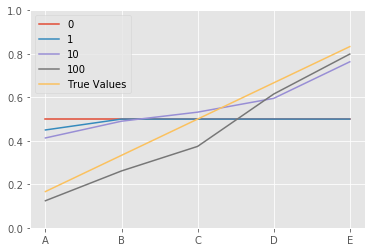

In [16]:
plt.style.use("ggplot")

to_plot = copy.deepcopy(rnd_walk_states)
to_plot.remove(rnd_walk_state_idxs[TERMINAL])

for n_episode in [0, 1, 10, 100]:
    state_values = run_rnd_td0(n_episode)
    plt.plot(
        to_plot, 
        [state_values[s] for s in to_plot],
        label=f"{n_episode}",
    )
    
plt.plot(
    list(true_values.keys()), 
    list(true_values.values()),
    label=f"True Values",
)
    
plt.ylim(0, 1)
plt.xticks([1, 2, 3, 4, 5], labels=["A", "B", "C", "D", "E"])
plt.legend()
plt.show()

### Optimality of TD(0)

*Batch Updating*: Given a small finite amount of experience, the increments specified by the update rules (e.g. Monte Carlo or TD) are summed and applied at the end of seeing all episodes rather than incrementally after each. 

Under batch updating, TD(0) converges deterministically to a single answer independent of the step-size parameter $\alpha$ as long as $\alpha$ is chosen to be sufficiently small. 

The constant-$\alpha$ MC method also converges deterministically under the same conditions but to a different answer. 

Understanding these two conditions will help us understand the difference between the two.

In [17]:
# Example 6.4: You are the Predictor
#
# Given the following eight episodes:
#     A, 0, B, 0
#     B, 1
#     B, 1
#     B, 1
#     B, 1
#     B, 1
#     B, 1
#     B, 0
#
# What are the values of states A and B?
#
# The optimal value for B, V(B), is 6/8=3/4 because 6 of the eight episodes the process terminates
# in state B with a reward of 1.
#
# What about V(A)? Following the same logic we arrive at V(A)=0. A different viewpoint is to 
# say that when in state A we always transitioned to state B, and state B has value 3/4 
# therefore state A has value V(A)=3/4
#
# The later is the answer TD(0) gives, the former is that MC methods give.

Batch Monte Carlo methods always find the estimates that minimize the mean-squared error on the training set.

Batch TD(0) always finds the estimates that would be exactly correct for the maximum-likelihood model of the Markov process. The _maximum-likelihood estimate_ of a parameter is a parameter whose probability of generating the dataset is greatest. In this case, the maximum-likelihood estimate is the model of the Markov process formed in the obvious way from the observed episodes: the estimated transition probabilities from i to j is the fraction of observed transitions from i that went to j, and the associated expected reward is the average of the rewards observed on those transitions.

Given this model, we can compute the estimate of the value function that would be exactly correct if the model were exactly correct. This is called the **certainty-equivalence estimate** because it is equivalent assuming that the estimate of the underlying process was known with certainty rather than being approximated. 

This helps explain why TD methods converge more quickly than Monte Carlo methods. In batch form, TD(0) is faster than MC methods because it computes the true certainty-equivalence estimate. This may also help explain the speed advantage of nonbatch estimates, although they do not achieve either the certainty-equivalence or the minimum squared-error estimates but can be seen as moving in this direction.

See: [Learning to Predict by the Methods of Temporal Differences](https://link.springer.com/content/pdf/10.1007%2FBF00115009.pdf)

---

Although certainty-equivalence estimate is in some sense optimal, it is almost never feasible to compute directly. If $n = |\mathcal{S}|$ is the number of states, then just forming the maximum-likelihood estimate of the process may require on the order of $n^2$ memory and computing the corresponding value function requires on the order of $n^3$ computational steps if done conventionally. 

---

### Sarsa: On-policy TD Control

Now to look at the control problem, following the same approach whereby we use generalized policy iteration (GPI). 

As per MC methods, we need to trade off exploration and exploitation. These approaches again fall into two main classes:

1. On-policy methods: Evaluate or improve the policy that is used to generate the data.
2. Off-policy methods: Evaluate or improve the policy that is different from the one used to generate the data.

As per MC, the first step is to learn the action-value function to avoid requiring a model of the environment:

\begin{align}
    Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [ R_{t + 1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)]
\end{align}

This update rule uses every quintuple of events: $(S_t, A_t, R_{t + 1}, S_{t + 1}, A_{t + 1})$

The quintuple gives rise to the name _Sarsa_ for the algorithm!

#### On-policy Control

As in all on-policy methods, we estimate $q_\pi$ for the behavior policy and at the same time drive $\pi$ towards greediness with respect to $q_\pi$. 

Sarsa converges with probability 1 to an optimal policy and action-value function as long as all state-action pairs are visited an infinite number of times and the policy converges in the limit to the greedy policy (which can be arranged, for example, with $\epsilon$-greedy policies by setting $\epsilon = 1/t$).

In [ ]:
def tabular_td0(
    policy: Mapping[StateT, Mapping[ActionT, float]],
    init_state: Callable[[], StateT],
    is_terminal: Mapping[StateT, bool],
    simulate: Callable[[StateT, ActionT], Tuple[StateT, RewardT]],
    n_episode: int,
    alpha: float = 0.1,
    gamma: float = 1.0,
    init_fn: Optional[Callable[[StateT], float]] = None
) -> Mapping[StateT, float]:

In [98]:
def sarsa_on_policy_td_control(
    state_actions: Mapping[StateT, Sequence[ActionT]],
    init_state: Callable[[], StateT],
    is_terminal: Mapping[StateT, bool],
    simulate: Callable[[StateT, ActionT], Tuple[StateT, RewardT]],
    n_episode: int,
    alpha: float,
    epsilon: float,
    gamma: float,
    init_fn: Optional[Callable[[StateT, ActionT], float]] = None
) -> Mapping[StateT, Mapping[ActionT, float]]:
    action_values = {}
    
    for state, actions in state_actions.items():
        action_values[state] = {}
        for action in actions:
            action_values[state][action] = init_fn(state, action) if init_fn is not None else 0.0
        
    for _ in tqdm.trange(n_episode):
        state = init_state()
        action = epsilon_greedy_sample(action_values[state], epsilon)
        
        while not is_terminal[state]:
            next_state, reward = simulate(state, action)
            next_action = epsilon_greedy_sample(action_values[next_state], epsilon)
            action_values[state][action] += (
                alpha * (
                    reward + gamma*action_values[next_state][next_action] 
                    - action_values[state][action]
                )
            )
            state = next_state
            action = next_action
    
    return action_values

        
def epsilon_greedy_sample(
    values: Mapping[ActionT, float],
    epsilon: float,
) -> ActionT:
    # epsilon percent of the time sample action randomly
    if random.random() < epsilon:
        return random.choice(list(values.keys()))
    
    # remaining (1.0 - epsilon) percent of time choose greedy action
    greedy_act = None
    greedy_val = -float("inf")
    for action, value in values.items():
        if value > greedy_val:
            greedy_act = action
            greedy_val = value
    return greedy_act

In [101]:
# Let's verify this appears to work by reconstructing the grid world state 
# values from above

In [102]:
gw_state_actions = {state: list(GWAction) for state in gw_states}

In [142]:
epsilon = 0.01

action_values = sarsa_on_policy_td_control(
    state_actions=gw_state_actions,
    init_state=gw_init_state,
    is_terminal=gw_is_terminal,
    simulate=gw_simulate,
    n_episode=int(1e6),
    alpha=0.0001,
    epsilon=epsilon,
    gamma=1.0
)

100%|██████████| 1000000/1000000 [00:07<00:00, 140882.18it/s]


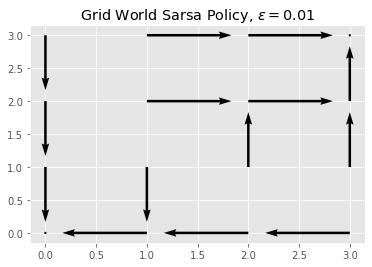

In [143]:
quiver_xs = list(range(4))
quiver_ys = list(range(4))

us = np.zeros((4, 4))
vs = np.zeros((4, 4))

for row in range(4):
    for col in range(4):
        state = 4*row + col
        if gw_is_terminal[state]:
            continue
            
        act_vals = action_values[state]
        greedy_act = max(act_vals.items(), key=lambda av: av[1])[0]
        
        if greedy_act == GWAction.LEFT:
            us[row][col] = -1
        elif greedy_act == GWAction.RIGHT:
            us[row][col] = 1
        elif greedy_act == GWAction.UP:
            vs[row][col] = -1
        elif greedy_act == GWAction.DOWN:
            vs[row][col] = 1

plt.quiver(quiver_xs, quiver_ys, us, vs, scale_units="xy", scale=1.2)
plt.title(f"Grid World Sarsa Policy, $\epsilon = {epsilon}$")
plt.show()

---

In [ ]:
# Exercise 6.8: Show than an action-value version of (6.6) holds for the action-value 
# form of the TD error, again assuming that the values don't change from step to step.

